# Salary Predictions Based on Job Descriptions

In [1]:
__author__ = "Nicolas Saunier"
__email__ = "nicsaunier@gmail.com"

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Predicting salaries is an important task for any business: making sure that staff are neither overpaid or underpaid helps optimize human resources management while avoiding excessive costs. In this notebook, we are going to try to extensively explore available training data on staff salaries in order to build a machine learning model that performs better than the benchmark.

## Part 2 - DISCOVER

### ---- 2 Load libraries, helper functions and data ----

In [2]:
## Importing libraries:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error

## Importing helper functions:

from Salary_pred_EDA_helpers import go_through_df, make_valid_training, make_all_boxplots, make_scatterplots, \
make_sidebyside_hists, make_colgroup_means, get_best_baseline

In [3]:
train_features = pd.read_csv('./data/train_features.csv')
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [4]:
train_salaries = pd.read_csv('./data/train_salaries.csv')

In [5]:
train_salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


#### merging features and target for training set

In [6]:
full_training = train_features.merge(train_salaries, left_on = 'jobId', right_on = 'jobId')
full_training.shape

(1000000, 9)

### ---- 3 Clean the data ----

(array([5.00000e+00, 2.44700e+03, 1.88630e+04, 4.66860e+04, 8.13050e+04,
        1.18643e+05, 1.46773e+05, 1.53004e+05, 1.37725e+05, 1.08907e+05,
        7.73940e+04, 5.02090e+04, 2.93930e+04, 1.58530e+04, 7.58900e+03,
        3.41800e+03, 1.27000e+03, 3.87000e+02, 1.09000e+02, 2.00000e+01]),
 array([  0.  ,  15.05,  30.1 ,  45.15,  60.2 ,  75.25,  90.3 , 105.35,
        120.4 , 135.45, 150.5 , 165.55, 180.6 , 195.65, 210.7 , 225.75,
        240.8 , 255.85, 270.9 , 285.95, 301.  ]),
 <BarContainer object of 20 artists>)

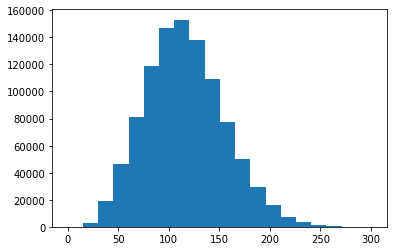

In [7]:
#checking the data for duplicates:

assert full_training.duplicated(subset = 'jobId').sum() == 0

#checking for invalid data 

#invalid values of the target variable
target = full_training['salary']
plt.hist(target, bins=20)


In [8]:
target.min()

0

In [9]:
target.max()

301

The distribution of salaries seems close to normal. We see that some values are 0, which are suspect; apart from that, it seems to be ok, no transformation of the target variable seems necessary.

In [10]:
valid_training = full_training[full_training['salary'] > 0]
valid_training.shape 

(999995, 9)

As we can see, 5 values which were 0 have been removed. Let's now make sure that there are no other outliers in predictor columns that could affect our model.

In [11]:
valid_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   jobId                999995 non-null  object
 1   companyId            999995 non-null  object
 2   jobType              999995 non-null  object
 3   degree               999995 non-null  object
 4   major                999995 non-null  object
 5   industry             999995 non-null  object
 6   yearsExperience      999995 non-null  int64 
 7   milesFromMetropolis  999995 non-null  int64 
 8   salary               999995 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [12]:
assert all(valid_training.isna().sum() == 0)
valid_training.describe()

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


The yearsExperience and milesFromMetropolis columns both seem to follow a uniform distribution.

### ---- 4 Explore the data (EDA) ----

In [13]:
#summarize each feature variable

valid_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   jobId                999995 non-null  object
 1   companyId            999995 non-null  object
 2   jobType              999995 non-null  object
 3   degree               999995 non-null  object
 4   major                999995 non-null  object
 5   industry             999995 non-null  object
 6   yearsExperience      999995 non-null  int64 
 7   milesFromMetropolis  999995 non-null  int64 
 8   salary               999995 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [14]:
go_through_df(valid_training)

Column jobId has more than 100 unique values. Examples include ['JOB1362684407687', 'JOB1362684407688']
Column companyId has between 20 and 100 unique values. Further exploration needed
Column jobType has 8 unique values: ['CFO', 'CEO', 'VICE_PRESIDENT', 'MANAGER', 'JUNIOR', 'JANITOR', 'CTO', 'SENIOR']
Column degree has 5 unique values: ['MASTERS', 'HIGH_SCHOOL', 'DOCTORAL', 'BACHELORS', 'NONE']
Column major has 9 unique values: ['MATH', 'NONE', 'PHYSICS', 'CHEMISTRY', 'COMPSCI', 'BIOLOGY', 'LITERATURE', 'BUSINESS', 'ENGINEERING']
Column industry has 7 unique values: ['HEALTH', 'WEB', 'AUTO', 'FINANCE', 'EDUCATION', 'OIL', 'SERVICE']
Column yearsExperience is numeric Mean 11.99 Min 0 Max 24
Column milesFromMetropolis is numeric Mean 49.53 Min 0 Max 99
Column salary is numeric Mean 116.06 Min 17 Max 301


Boxplot of the target variable:

{'whiskers': [<matplotlib.lines.Line2D at 0x7f60af208880>,
 'caps': [<matplotlib.lines.Line2D at 0x7f60af208f40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f60af208160>],
 'medians': [<matplotlib.lines.Line2D at 0x7f60af216640>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f60af2169a0>],
 'means': []}

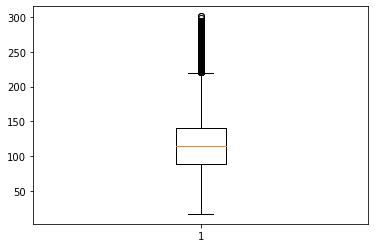

In [15]:
target = valid_training['salary']
plt.boxplot(target)

As we can see from the boxplot:
- there are no outliers at the bottom part of the interquartile range (that said, it goes down to almost 0)
- values seem to be mostly concentrated in a pretty narrow 90 to 150 range
- there are a lot of outliers at the top; this can be expected, because there is a limit to how low salaries can go but not that much to how high they can go


### Looking for correlation between each feature and the target

For this we use our helper functions that make it possible to automatically look at all the columns of interest

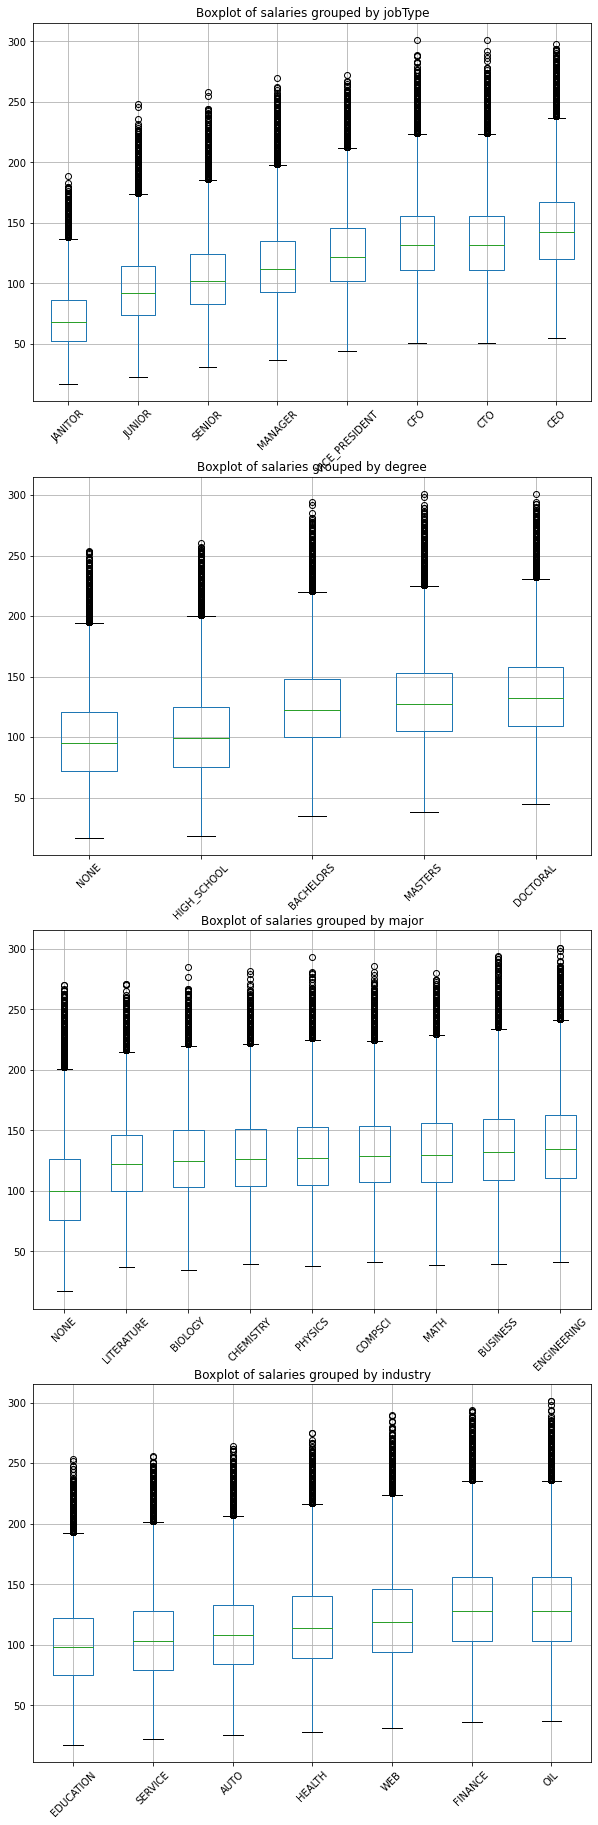

In [16]:
make_all_boxplots(valid_training)

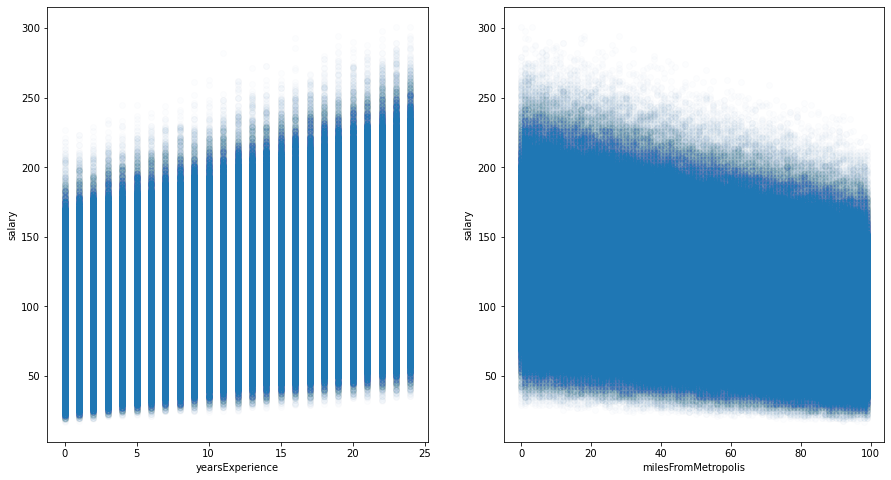

In [17]:
make_scatterplots()

The above graphs show the following things;
- Within each category, there are huge discrepancies, meaning that inner category variance is much higher than the percentage of variance explained by any category; There are big salary ranges for all levels of education, all types of degrees, all job types, everything basically; so making a linear model with one or two variables probably isn't going to cut it, each variable seems important.  
- Nevertheless, the differences in means between categories generally make sense, and correspond to what we might expect given the prestige of positions, the number of years of study to obtain degrees, and common knowledge about majors or sectors that pay well.
- Salaries increase with yearsExperience and decrease with milesFromMetropolis: while in general, the scatterplots are completely packed with data, so that even maximum transparency make the density barely visible, we can see that there are clearly fewer jobs that pay a lot far from the city center or with few years of experience.


Below, for further exploration, we will look at the top 20% and bottom 20% of salaries specifically to see what trends we can identify.


#### Histograms for all positions (blue), low paying positions (red) and high paying positions (green), side by side.

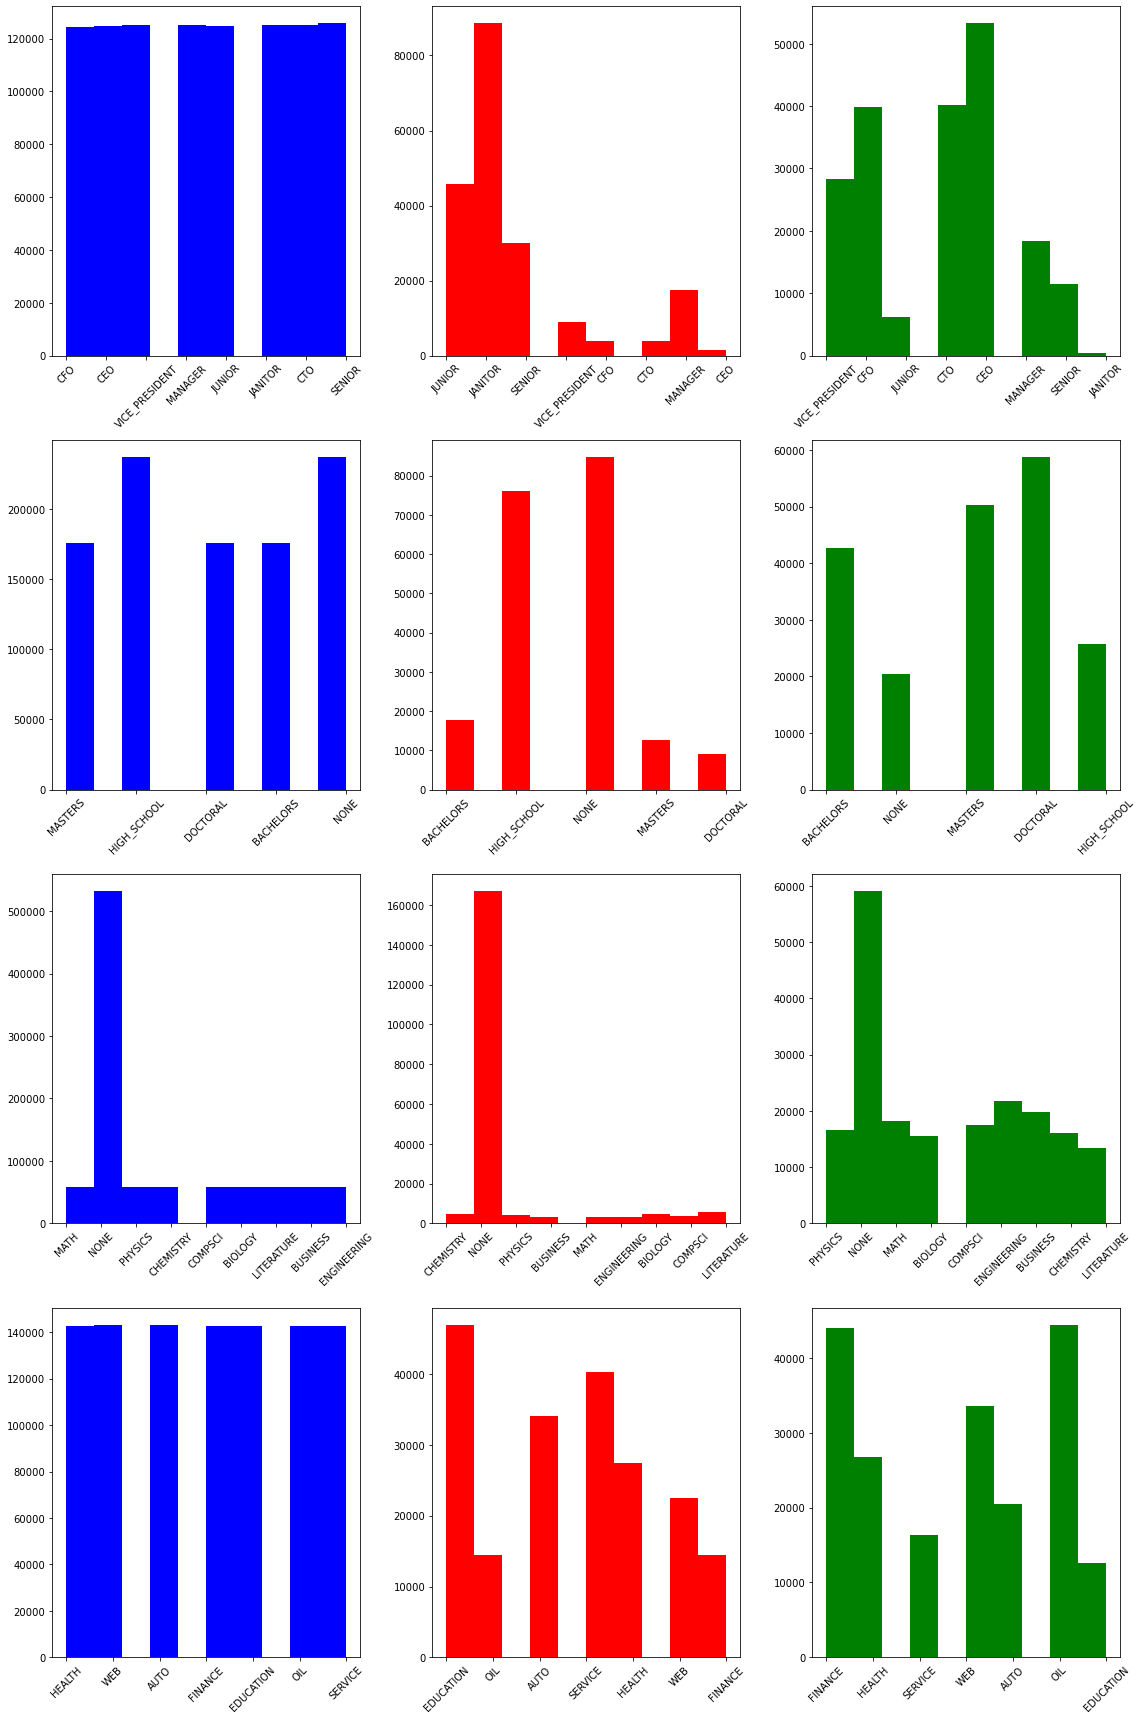

In [18]:
make_sidebyside_hists()

Job types are about equally represented in the general table, but janitor and junior positions are over-represented in the low paying jobs and CEO / CTO / CFO are over-represented in the high paying jobs; nothing is very surprising in these results.  

What's to be noted is that many positions don't specify any major, so the sub-samples of graduates of any major are much smaller. Any kind of university degree and any kind of major is generally associated with higher salaries than the mean for the whole dataset.



### ---- 5 Establish a baseline ----

Before advancing on exploration of advanced features and their impact, which is something that we will do later, we're going to establish a baseline.   
Mean squared error and Root Mean Squared Error are good metrics for our model, because we care more about large errors than about small ones.  

At the very least, our model should outperform any model that predicts the average salary by category for categories taken from a single column in the data. Let's measure the mean squared error of that model.

In [19]:
colgroup_means = make_colgroup_means(valid_training)

In [20]:
get_best_baseline(colgroup_means)

Mean squared error of predictions using jobType_mean : 964.0
Mean squared error of predictions using degree_mean : 1258.0
Mean squared error of predictions using major_mean : 1284.0
Mean squared error of predictions using industry_mean : 1367.0


The best baseline prediction takes jobType_mean as its predictor and has a mean squared error of 964.0, which corresponds to a root mean squared error of 31.0


Our baseline is a mean squared error of around 964, i.e predictions which are off by slightly more than $31k from the reality. Obviously, these predictions take into account only one parameter, so we can expect any model which takes multiple parameters into account to produce much better predictions.
Our target is to reduce the mean squared error below 360, which means about 19 k difference between real salaries and estimated salaries.

### ---- 6 Hypothesize solution ----

This is a regression problem, but a lot of categorical variables play a big role; based on our EDA, we can expect all variables to be somewhat important predictors of the salaries. Linear regression will be attempted because it is extremely fast to train and easy to interpret. If there are complex, non linear interactions between variables, for example certain types of degrees being highly valued in some sectors but not in others, it is possible that tree based regression models will produce better results. However, since basic decision tree models are highly prone to overfitting, ensemble tree methods are preferred to regular decision trees. XGBoost is a good choice because of its combination of speed and accuracy.

One hypothesis that needs to be tested is that the number of prestigious requirements (number of categorical variables that the job required that were above certain threshold) has a non linear relationship with salaries; basically, what counts is having a rare skills stack rather than just a degree or a certain position. In this case, residual analysis should show the need for more feature engineering.

Another hypothesis to test is that of non-linear interactions between variables, which tree based methods will capture better than linear regression.

We will try 2 models: Linear Regression, and XGBoost DecisionTrees Regression, and compare the results to select our final model.